# Prototyping a Mixture of Double Poissons

This notebook demonstrates how one might create a mixture model from trained double poisson neural nets, weighting each model's contribution to the mixture by their measured MSE on a holdout set. It investigates the behavior of such a mixture in comparison to its individual models.

## Setup

In [1]:
import os
from typing import Callable, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from deep_uncertainty.evaluation.calibration import compute_average_calibration_score, plot_regression_calibration_curve
from deep_uncertainty.evaluation.metrics import get_mse, get_calibration, get_med_se
from deep_uncertainty.evaluation.plots import get_sigma_plot_from_test
from deep_uncertainty.models.random_variables import DoublePoisson
from deep_uncertainty.models.old_regressors import RegressionNN
from deep_uncertainty.utils.generic_utils import get_yaml
from deep_uncertainty.utils.model_utils import train_regression_nn

In [2]:
config = get_yaml("../toy/toy_exp_train_config.yaml")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data = np.load(os.path.join("..", config['dataset']["dir"].replace(".", ".."), config['dataset']["name"] + ".npz"))
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val = data["X_val"], data["y_val"]
X_test, y_test = data["X_test"], data["y_test"]

In [4]:
train_dataset = TensorDataset(
    torch.Tensor(X_train.reshape(-1, 1)),
    torch.Tensor(y_train.reshape(-1, 1))
)
val_dataset = TensorDataset(
    torch.Tensor(X_val.reshape(-1, 1)),
    torch.Tensor(y_val.reshape(-1, 1))
)
test_dataset = TensorDataset(
    torch.Tensor(X_test.reshape(-1, 1)),
    torch.Tensor(y_test.reshape(-1, 1))
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [14]:
num_trials = 3
num_epochs = 1000

In [7]:
def train_model(model: RegressionNN, criterion: Callable) -> Tuple[nn.Module, List[float], List[float]]:
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    
    progress_bar = tqdm(range(num_epochs), desc="Training", unit="epoch")
    trn_losses = []

    for _ in progress_bar:

        train_loss = train_regression_nn(
            train_loader=train_loader,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
        )
        scheduler.step()

        progress_bar.set_postfix({"Train Loss": f"{train_loss:.4f}"})
        trn_losses.append(train_loss)
    
    return model, trn_losses

In [8]:
def evaluate_model(model: nn.Module, outputs_to_rv: Callable, rv_to_mu: Callable, plot: bool = False) -> Dict[str, float]:
    with torch.inference_mode():
        outputs = []
        y_vals = []
        model.eval()
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs.append(model(X))
            y_vals.extend(y)

    outputs = torch.cat(outputs)
    posterior = outputs_to_rv(outputs)
    y_vals = np.array(y_vals).flatten()

    # Evaluation metrics / plots.

    mu_vals = rv_to_mu(posterior)
    test_mse = get_mse(y_vals, mu_vals)
    test_med_se = get_med_se(y_vals, mu_vals)
    
    lower = posterior.ppf(0.025)
    upper = posterior.ppf(0.975)
    test_calib = get_calibration(y_vals, upper, lower)
    mean_calib = compute_average_calibration_score(y_vals, posterior)
    
    if plot:
        get_sigma_plot_from_test(X_test, y_test, mu_vals, upper=upper, lower=lower)
        plot_regression_calibration_curve(
            y_true=y_vals,
            posterior_predictive_distribution=posterior,
            num_bins=15,
        )
    
    return {"mse": test_mse, "med_se": test_med_se, "calibration@0.95": test_calib, "mean_calibration": mean_calib}

In [9]:
def double_poisson_nll(output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """Compute the mean double poisson negative log likelihood over the given targets.

    Args:
        output (torch.Tensor): The (n, 2) output from a DoublePoissonNN. Dims along last axis are assumed to be logmu, logphi.
        targets (torch.Tensor): Regression targets for the DoublePoissonNN. Shape: (n, 1).
        reduce (bool, optional): Whether/not to return the avg. loss across targets. Defaults to True.

    Returns:
        torch.Tensor: Avg. loss across all targets. Zero-dimensional tensor (torch.Size([])).
    """
    eps = 1e-5
    logmu, logphi = torch.split(output, [1, 1], dim=-1)
    phi = torch.exp(logphi)
    mu = torch.exp(logmu)
    losses = (-0.5 * logphi) + phi*mu - (targets*phi*(1 + logmu - torch.log(targets + eps)))
    return losses.mean()

def double_poisson_outputs_to_rv(outputs: torch.Tensor) -> DoublePoisson:
    mu, phi = torch.split(outputs, [1, 1], dim=-1)
    mu_vals, phi_vals = mu.flatten().numpy(), phi.flatten().numpy()
    return DoublePoisson(mu_vals, phi_vals)

def double_poisson_rv_to_mu(rv: DoublePoisson) -> np.ndarray:
    return rv.mu

## Training

We will train 3 Double Poisson regression neural networks for 1000 epochs on a toy dataset and then ensemble their outputs via a mixture model.

Training:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training: 100%|██████████| 1000/1000 [00:22<00:00, 44.22epoch/s, Train Loss=-0.4200]


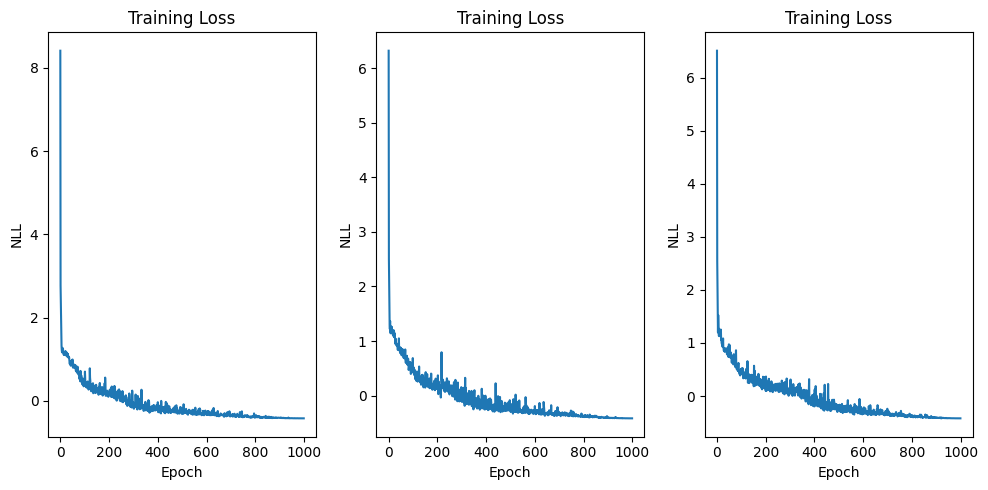

In [15]:
double_poisson_models = []
fig, axs = plt.subplots(1, num_trials, figsize=(10, 5))

for trial, ax in zip(range(num_trials), axs.ravel()):

    model = RegressionNN(input_dim=1, output_dim=2, log_dims=[True, True])
    model, trn_losses = train_model(model, double_poisson_nll)
    double_poisson_models.append(model)

    ax.plot(trn_losses)
    ax.set_title("Training Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("NLL")

plt.tight_layout()
plt.show()

Evaluating Double Poisson models...:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluation plots for model 0


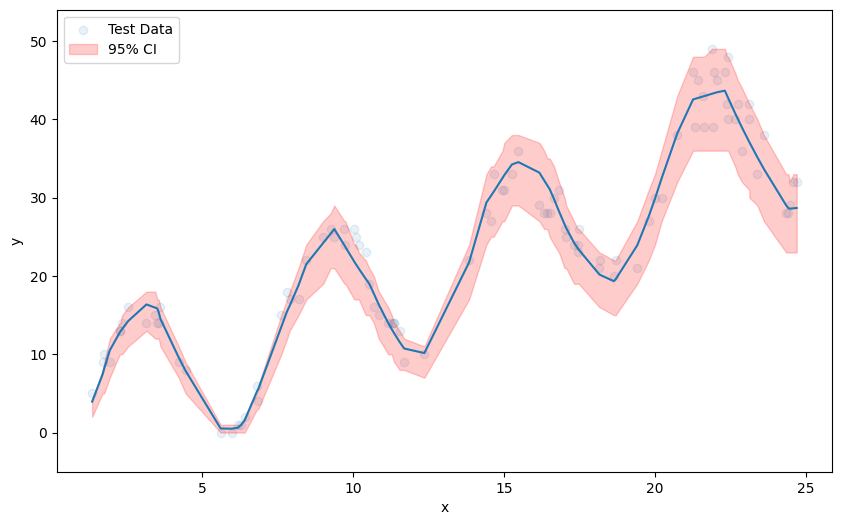

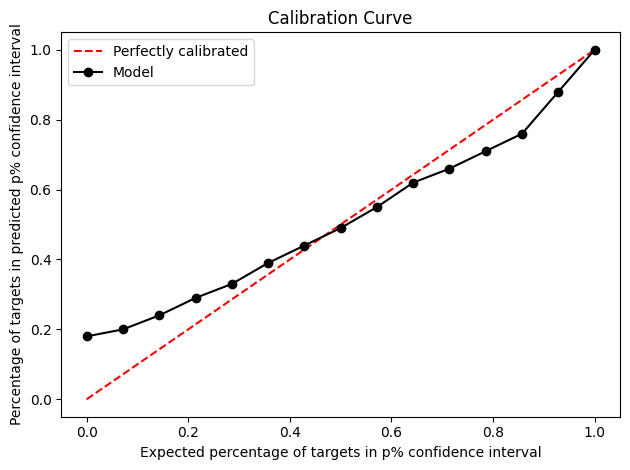

Evaluating Double Poisson models...:  33%|███▎      | 1/3 [00:12<00:24, 12.08s/it]

Evaluation plots for model 1


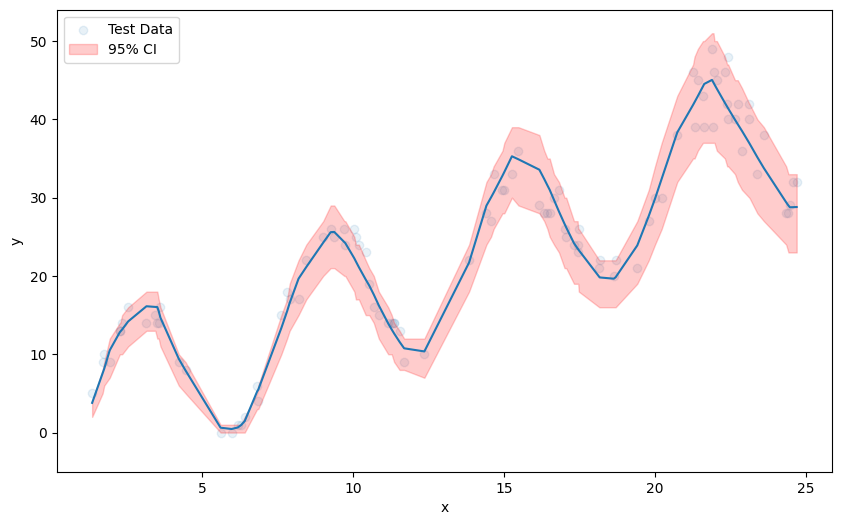

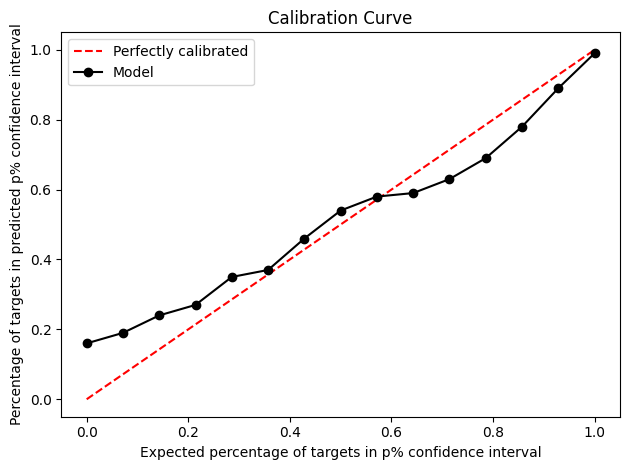

Evaluating Double Poisson models...:  67%|██████▋   | 2/3 [00:24<00:12, 12.10s/it]

Evaluation plots for model 2


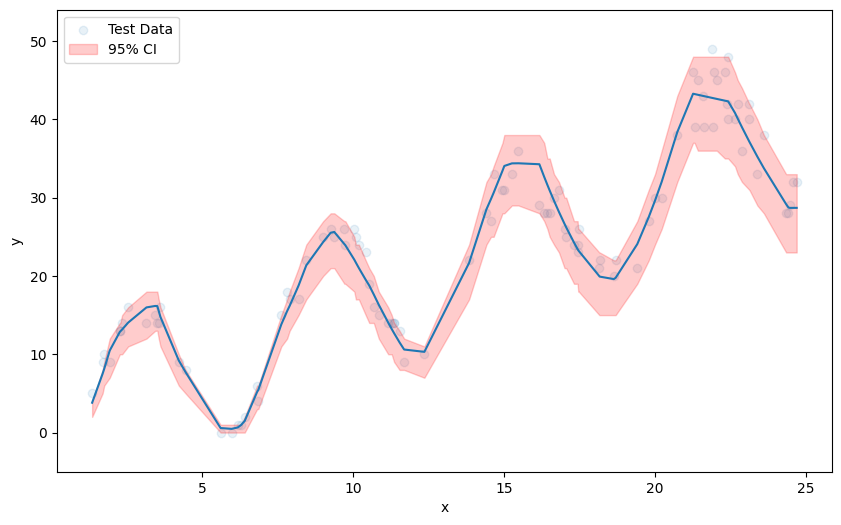

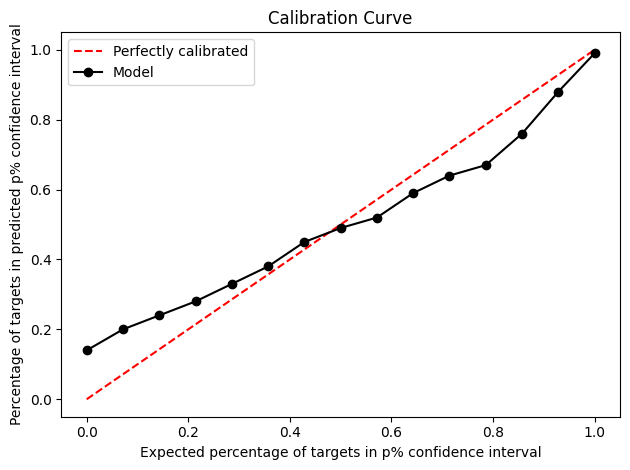

Evaluating Double Poisson models...: 100%|██████████| 3/3 [00:36<00:00, 12.07s/it]


In [16]:
double_poisson_mse = []
double_poisson_med_se = []
double_poisson_calibration_at_95 = []
double_poisson_mean_calibration = []

eval_loop = tqdm(double_poisson_models, desc="Evaluating Double Poisson models...")

for n, model in enumerate(eval_loop):
    print(f"Evaluation plots for model {n}")
    metrics = evaluate_model(model, double_poisson_outputs_to_rv, double_poisson_rv_to_mu, plot=True)
    double_poisson_mse.append(metrics["mse"])
    double_poisson_med_se.append(metrics["med_se"])
    double_poisson_calibration_at_95.append(metrics["calibration@0.95"])
    double_poisson_mean_calibration.append(metrics["mean_calibration"])

In [17]:
print(f"Model MSEs: {double_poisson_mse}")
print(f"Model Calibrations @ 0.95: {double_poisson_calibration_at_95}")
print(f"Model Young Calibrations: {double_poisson_mean_calibration}")

Model MSEs: [4.830324, 5.1563044, 5.1339097]
Model Calibrations @ 0.95: [0.91, 0.91, 0.92]
Model Young Calibrations: [0.8837891630566221, 0.8754485421083921, 0.88106882458061]


Among the models trained, one is clearly better than the others (with a lower MSE on the test set.) We now create a mixture of these models, with weight in the mixture inversely proportional to MSE on the test set:

## Forming a Mixture

In [18]:
class DoublePoissonMixture:
    def __init__(self, distributions: list[DoublePoisson], weights: np.ndarray):
        self.distributions = distributions
        self.weights = weights
        self.expected_value = np.dot(self.weights, np.array([x.mu for x in self.distributions]))

    def pmf(self, x: int | np.ndarray) -> float | np.ndarray:
        """Calculate the probability that this random variable takes on the value(s) x.

        Args:
            x (int | np.ndarray): The value(s) to compute the probability of.

        Returns:
            probability (float | np.ndarray): The probability of x.
        """
        probabilities = []
        for distribution in self.distributions:
            probabilities.append(distribution.pmf(x))
        probabilities = np.stack(probabilities, axis=0)
        return np.average(probabilities, weights=self.weights, axis=0)

    def ppf(self, q: float) -> int | np.ndarray:
        """Return the largest possible value of this random variable at which the probability mass to the left is less than or equal to `q`.

        Args:
            q (float): The desired quantile.

        Returns:
            int | np.ndarray: The largest value at which this distribution has mass <= `q` to the left of it.
        """
        truncated_support = np.arange(2000).reshape(-1, 1)
        mass = self.pmf(truncated_support)
        mass = mass / mass.sum(axis=0)  # Sometimes, the resultant mass isn't entirely normalized.
        mask = np.cumsum(mass, axis=0) <= q
        values = len(mass) - np.argmax(mask[::-1], axis=0) - 1
        values[mask.sum(axis=0) == 0] = 0
        return values.item() if values.size == 1 else values

In [20]:
# Collect model parameters for entire test set.
with torch.inference_mode():
    outputs = {i: [] for i in range(len(double_poisson_models))}
    y_vals = []
    [model.eval() for model in double_poisson_models]
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        for i, model in enumerate(double_poisson_models):
            outputs[i].append(model(X))
        y_vals.extend(y)

# Form Double Poissons from the output parameters.
posteriors = {}    
for i in outputs.keys():
    outputs[i] = torch.cat(outputs[i])
    posteriors[i] = double_poisson_outputs_to_rv(outputs[i])
y_vals = np.array(y_vals).flatten()

# Create the mixture with weights inversely proportional to MSE.
weights = 1 / np.array(double_poisson_mse)
weights = weights / weights.sum()
mix_posterior = DoublePoissonMixture(distributions=list(posteriors.values()), weights=weights)

In [23]:
mu_vals = mix_posterior.expected_value
mixture_mse = get_mse(y_vals, mu_vals)
lower = mix_posterior.ppf(0.025)
upper = mix_posterior.ppf(0.975)
mixture_calib_95 = get_calibration(y_vals, upper, lower)
mixture_mean_calib = compute_average_calibration_score(y_vals, mix_posterior)

print(f"Mixture MSE: {mixture_mse}")
print(f"Mixture Calibration @ 0.95: {mixture_calib_95}")
print(f"Mixture Young Calibration: {mixture_mean_calib}")

Mixture MSE: 4.961475372314453
Mixture Calibration @ 0.95: 0.93
Mixture Young Calibration: 0.8838324446698962


In this case, the mixture is nearly as accurate as the best model in the ensemble, and its calibration is comparable (or even slightly better) than any of the individual models. There appears to be some benefit here from the model averaging that could also result in better generalization on yet unseen data (or more diverse data -- in this toy experiment, the train and test distributions are quite similar).

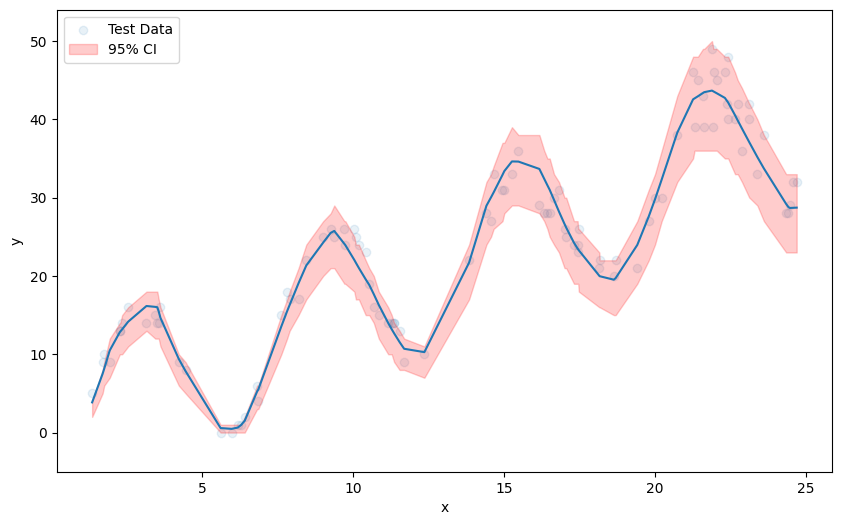

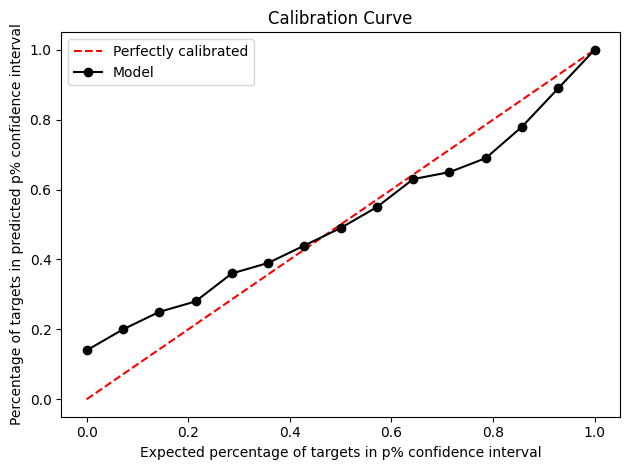

In [24]:
get_sigma_plot_from_test(X_test, y_test, mu_vals, upper=upper, lower=lower)
plot_regression_calibration_curve(
    y_true=y_vals,
    posterior_predictive_distribution=mix_posterior,
    num_bins=15,
)

## Injecting a "Bad" Model

How does this mixture technique perform when a defective model is included in the ensemble? For the sake of demonstration, we investigate the impact of a totally untrained model.

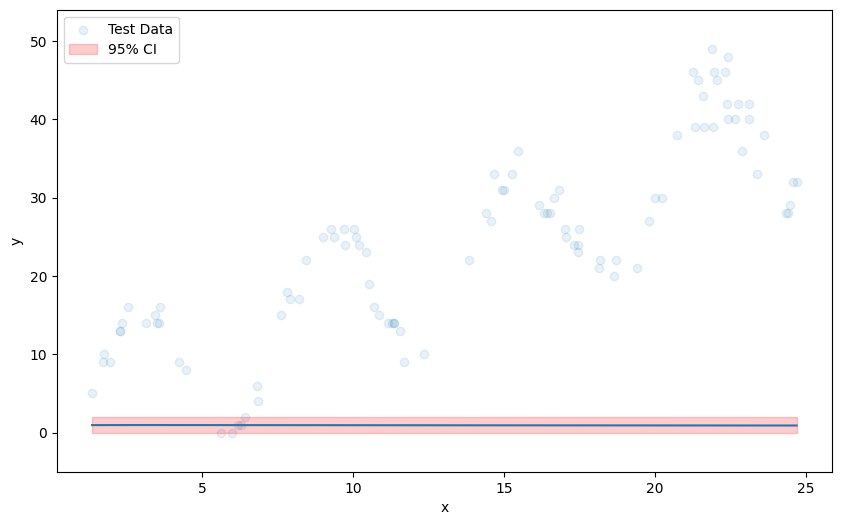

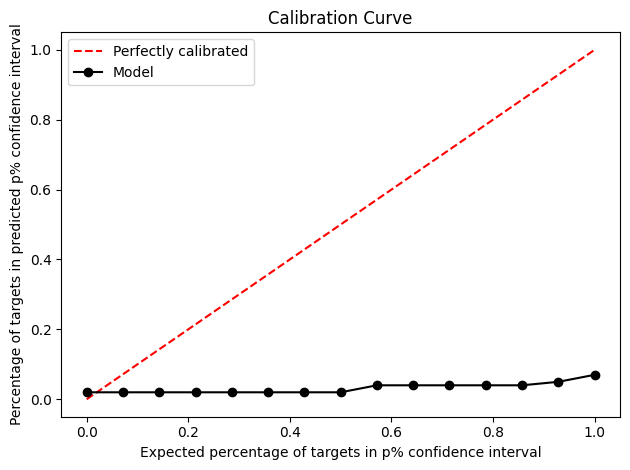

{'mse': 693.57404,
 'med_se': 578.7583,
 'calibration@0.95': 0.05,
 'mean_calibration': 0.06099765710384386}

In [26]:
defective_model = RegressionNN(input_dim=1, output_dim=2, log_dims=[True, True])
defective_metrics = evaluate_model(defective_model, double_poisson_outputs_to_rv, double_poisson_rv_to_mu, plot=True)
defective_metrics

In [28]:
defective_ensemble = [*double_poisson_models, defective_model]

with torch.inference_mode():
    outputs = {i: [] for i in range(len(defective_ensemble))}
    y_vals = []
    [model.eval() for model in defective_ensemble]
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        for i, model in enumerate(defective_ensemble):
            outputs[i].append(model(X))
        y_vals.extend(y)

posteriors = {}    
for i in outputs.keys():
    outputs[i] = torch.cat(outputs[i])
    posteriors[i] = double_poisson_outputs_to_rv(outputs[i])
y_vals = np.array(y_vals).flatten()

defective_ensemble_weights = 1 / np.array([*double_poisson_mse, defective_metrics["mse"]])
defective_ensemble_weights = defective_ensemble_weights / defective_ensemble_weights.sum()
defective_mixture = DoublePoissonMixture(distributions=list(posteriors.values()), weights=defective_ensemble_weights)

In [29]:
mu_vals = defective_mixture.expected_value
defective_mixture_mse = get_mse(y_vals, mu_vals)
lower = defective_mixture.ppf(0.025)
upper = defective_mixture.ppf(0.975)
defective_mixture_calib_95 = get_calibration(y_vals, upper, lower)
defective_mixture_mean_calib = compute_average_calibration_score(y_vals, defective_mixture)

print(f"Mixture MSE: {defective_mixture_mse}")
print(f"Mixture Calibration @ 0.95: {defective_mixture_calib_95}")
print(f"Mixture Young Calibration: {defective_mixture_mean_calib}")

Mixture MSE: 4.988959789276123
Mixture Calibration @ 0.95: 0.93
Mixture Young Calibration: 0.8840573756603024


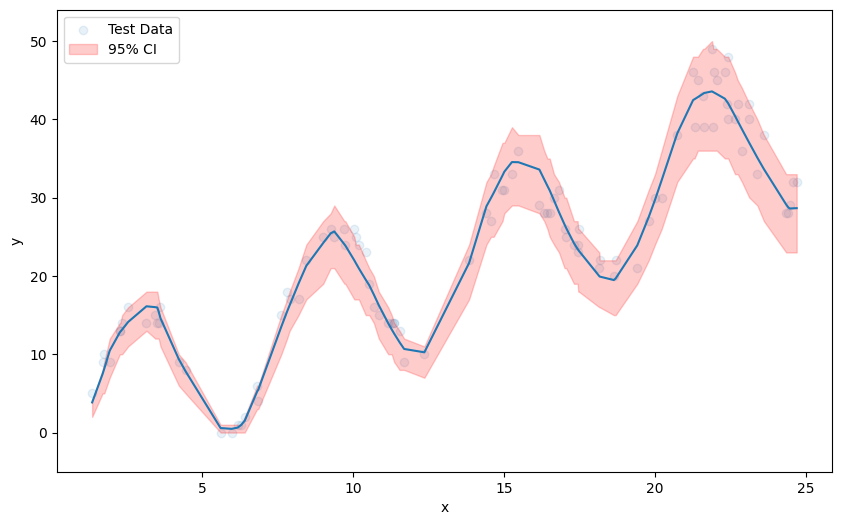

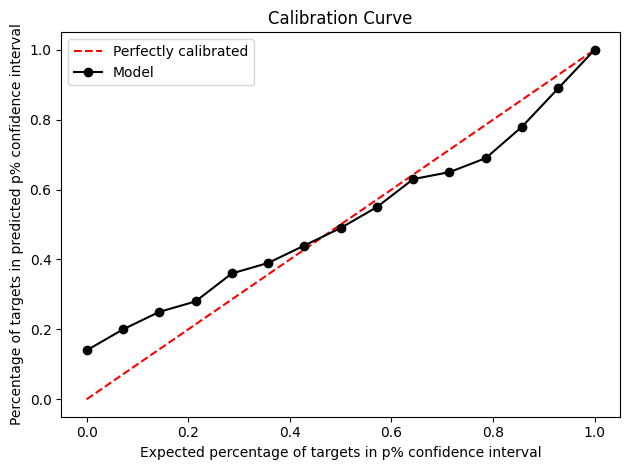

In [30]:
get_sigma_plot_from_test(X_test, y_test, mu_vals, upper=upper, lower=lower)
plot_regression_calibration_curve(
    y_true=y_vals,
    posterior_predictive_distribution=mix_posterior,
    num_bins=15,
)

Despite the presence of a defective model, the weighting technique used to build the mixture was able to correct for total failure. Thus, as long as a representative validation set is available on which MSE may be estimated, a mixture of Double Poissons formed in this way should be robust to poor training runs.